# Overview

The objective for this assignment is to look at the results for the boston marathon in 2014, and see what kind of observations we can generate from unsupervised clustering methods, and also determine what is the best clustering method for this dataset.

In [1]:
# Import statements
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from datetime import time
%matplotlib inline

In [2]:
# Machine learning packages
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
# Retrive the data
with open("bostonmarathon-master/results/2014/results.pkl", 'rb') as f:
    data = pickle.load(f)
marathon = pd.DataFrame.from_dict(data).transpose()

In [4]:
marathon.shape

(31984, 21)

So the dataset contains a collection of 31984 participants, and 21 features for each participant.

In [5]:
marathon.dtypes

10k          object
20k          object
25k          object
30k          object
35k          object
40k          object
5k           object
age          object
bib          object
city         object
country      object
ctz          object
division     object
gender       object
genderdiv    object
half         object
name         object
official     object
overall      object
pace         object
state        object
dtype: object

Well, this isn't very useful. Every feature has been identified as an object. Let's take a look at the dataset and determine what type each feature should be.

In [6]:
# Print raw data
marathon.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,...,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
35540,0:58:22,2:01:01,2:42:47,3:21:59,4:07:49,4:45:17,0:29:52,30,35540,New York,...,CHN,5258,M,15604,2:08:38,"Zheng, Jiewu",5:06:24,27767,0:11:42,NY
35541,0:57:18,1:53:23,2:21:10,2:49:51,3:18:27,3:46:28,0:29:16,37,35541,Brunswick,...,,3767,F,6676,1:59:27,"Harrington, Kim L.",3:58:20,17647,0:09:06,OH
35542,1:02:28,2:15:31,2:57:57,3:36:45,4:12:27,4:56:56,0:31:03,37,35542,Boston,...,,5385,M,15885,2:24:34,"Gupta, Alok",5:12:24,28283,0:11:55,MA
35543,0:51:05,1:44:33,2:17:28,2:55:33,3:37:50,4:15:28,0:26:08,45,35543,Dorchester,...,,2445,M,13736,1:50:49,"Higgins, David J.",4:32:38,23843,0:10:24,MA
35544,1:19:19,2:47:08,-,4:30:17,5:21:07,6:08:52,0:40:21,22,35544,Waquoit,...,,6882,F,14150,2:57:27,"Bohnenberger, Helen",6:28:10,31567,0:14:49,MA


So, it seems like the dataset can be broken down to time, categorical, and numerical variables. 
1. Clustering can't process the time as it is, so these features will have to be converted into seconds, which can easily be normalized, and repurposed for the model.
2. Categorical variables can be assigned arbitrary numerical values, but that doesn't tell us anything and would only obscure the results, so those has will have to be dropped for this model.
3. Numerical values are simple and straightforward to convert.

In [7]:
# Remove non-numeric features
marathon.drop(['bib', 'city', 'country', 'ctz', 'name', 'state', 'gender'], 1, inplace=True)

# Convert all time variables into seconds
times = ['5k', '10k', '20k', '25k', '30k', '35k', '40k', 'half', 'official', 'pace']
for time in times:
    marathon[time] = pd.to_timedelta(marathon[time])
    marathon[time] = marathon[time].dt.seconds

# Convert numerical variables
marathon[['age', 'division', 'genderdiv', 'overall']] = marathon[['age', 'division', 'genderdiv', 'overall']].apply(pd.to_numeric, errors='coerce')

# Create target variable
y = preprocessing.scale(marathon.official)

# Drop target variable from original dataset
marathon.drop(['official'], axis=1, inplace=True)

C:\Users\nu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [9]:
# View formatted data
marathon.head()

,10k,20k,25k,30k,35k,40k,5k,age,division,genderdiv,half,overall,pace
35540,3502,7261,9767,12119,14869,17117,1792,30,5258,15604,7718,27767,702
35541,3438,6803,8470,10191,11907,13588,1756,37,3767,6676,7167,17647,546
35542,3748,8131,10677,13005,15147,17816,1863,37,5385,15885,8674,28283,715
35543,3065,6273,8248,10533,13070,15328,1568,45,2445,13736,6649,23843,624
35544,4759,10028,0,16217,19267,22132,2421,22,6882,14150,10647,31567,889


Here, we have all of the variables that will be used in our model, but one issue still persists. The values for each feature can't be compared as is since the scales are all off. It's not possible to compare the values between age, pace, and time, so these features will have to be normalized before running the model.

In [10]:
y = marathon['overall']

# Normalize
X_norm = normalize(marathon)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

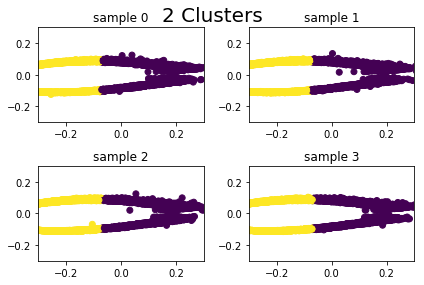



1.6422309107061604e-07


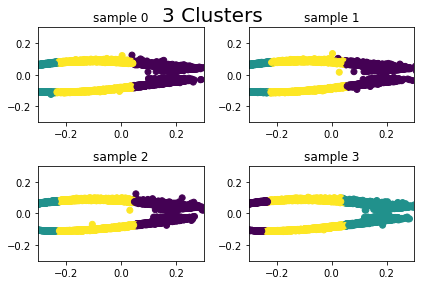



1.6422309107061604e-07


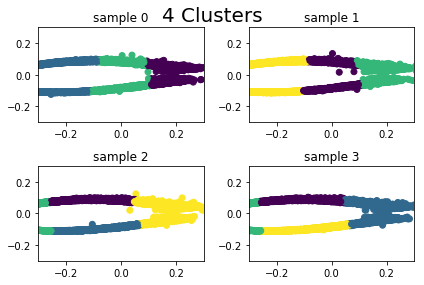



1.6422309107061604e-07


In [18]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')
    print(metrics.adjusted_rand_score(y, full_pred))

In [15]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

1.6422309107061604e-07

In [21]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X1, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X1)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 27


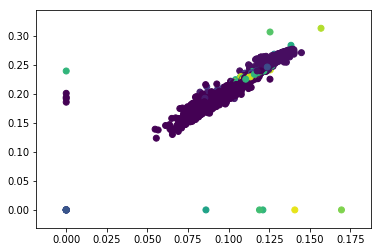

Comparing the assigned categories to the ones in the data:


NameError: name 'y_train' is not defined

In [22]:
plt.scatter(X1[:, 0], X1[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))